In [1]:
% make summary plot on sensitivity: EnKF, EnKS, SFSM
% v2: include errorbar, different legend: sensor location
clear;
close all;

## define hyperparameters

In [2]:
inputname1 = './data_transient/transient_1d_conduction_pulse1.mat';
% will need: 'time_grid','T_transient','R_transient','q_transient'

% x-axis: r_step. y-axis: q_error, legend: different hyperparameter (one at a time)
sigma_noise = 0.1; % [K] measurement noise
Rgap_noise = 0.1; % [ratio] gap thermal resistance modeling error
q_noise = 10^8; % [W/m^3]
r_steps = [1, 2, 3, 5, 7, 10];
dt = 0.25; % inverse time step
sensor_user_input = [66, 106, 146]; % grid index. 86 is gap location
M_sample = 50;

Nr = length(r_steps);
Np = max([length(sigma_noise), length(Rgap_noise), length(q_noise), length(dt), length(sensor_user_input)]);

## Filtering/smoothing

In [3]:
q_error_normalized_save_EnK = zeros(Nr, Np); % to save result
q_std_normalized_save_EnK = zeros(Nr, Np); % std of mean estimation
T_peak_error_save_EnK = zeros(Nr, Np);
T_peak_std_save_EnK = zeros(Nr, Np);

for ip=1:Np
    for ir=1:Nr
        if r_steps(ir) == 1
            [q_error_normalized_save_EnK(ir, ip), q_std_normalized_save_EnK(ir, ip), T_peak_error_save_EnK(ir, ip), T_peak_std_save_EnK(ir, ip) ] ...
               = EnKF_augmented_1d_conduction_heater_Rgap_insulation_f(...
            sigma_noise, Rgap_noise, q_noise, dt, sensor_user_input(ip), M_sample, inputname1);
        elseif r_steps(ir) > 1
            [q_error_normalized_save_EnK(ir, ip), q_std_normalized_save_EnK(ir, ip), T_peak_error_save_EnK(ir, ip), T_peak_std_save_EnK(ir, ip) ] ...
                = EnKS_augmented_1d_conduction_heater_Rgap_insulation_f(...
            sigma_noise, Rgap_noise, q_noise, r_steps(ir), dt, sensor_user_input(ip), M_sample, inputname1);
        end
    end
end

## sensor location

In [4]:
ro_heater = 4.25*10^-3; % [m]
ro_zro2 = 30.70*10^-3; % [m] instead of 30.734 mm
dr = 0.05*10^-3; % [m] grid size: can be greater than greatest common divisor of two lengths

r_grid_heater = linspace(0, ro_heater, 1+ro_heater/dr)'; % including interface
N_grid_heater = length(r_grid_heater);

## plot result

In [5]:
figure;
set(gcf, 'WindowState', 'maximized');

## heat source reconstruction error


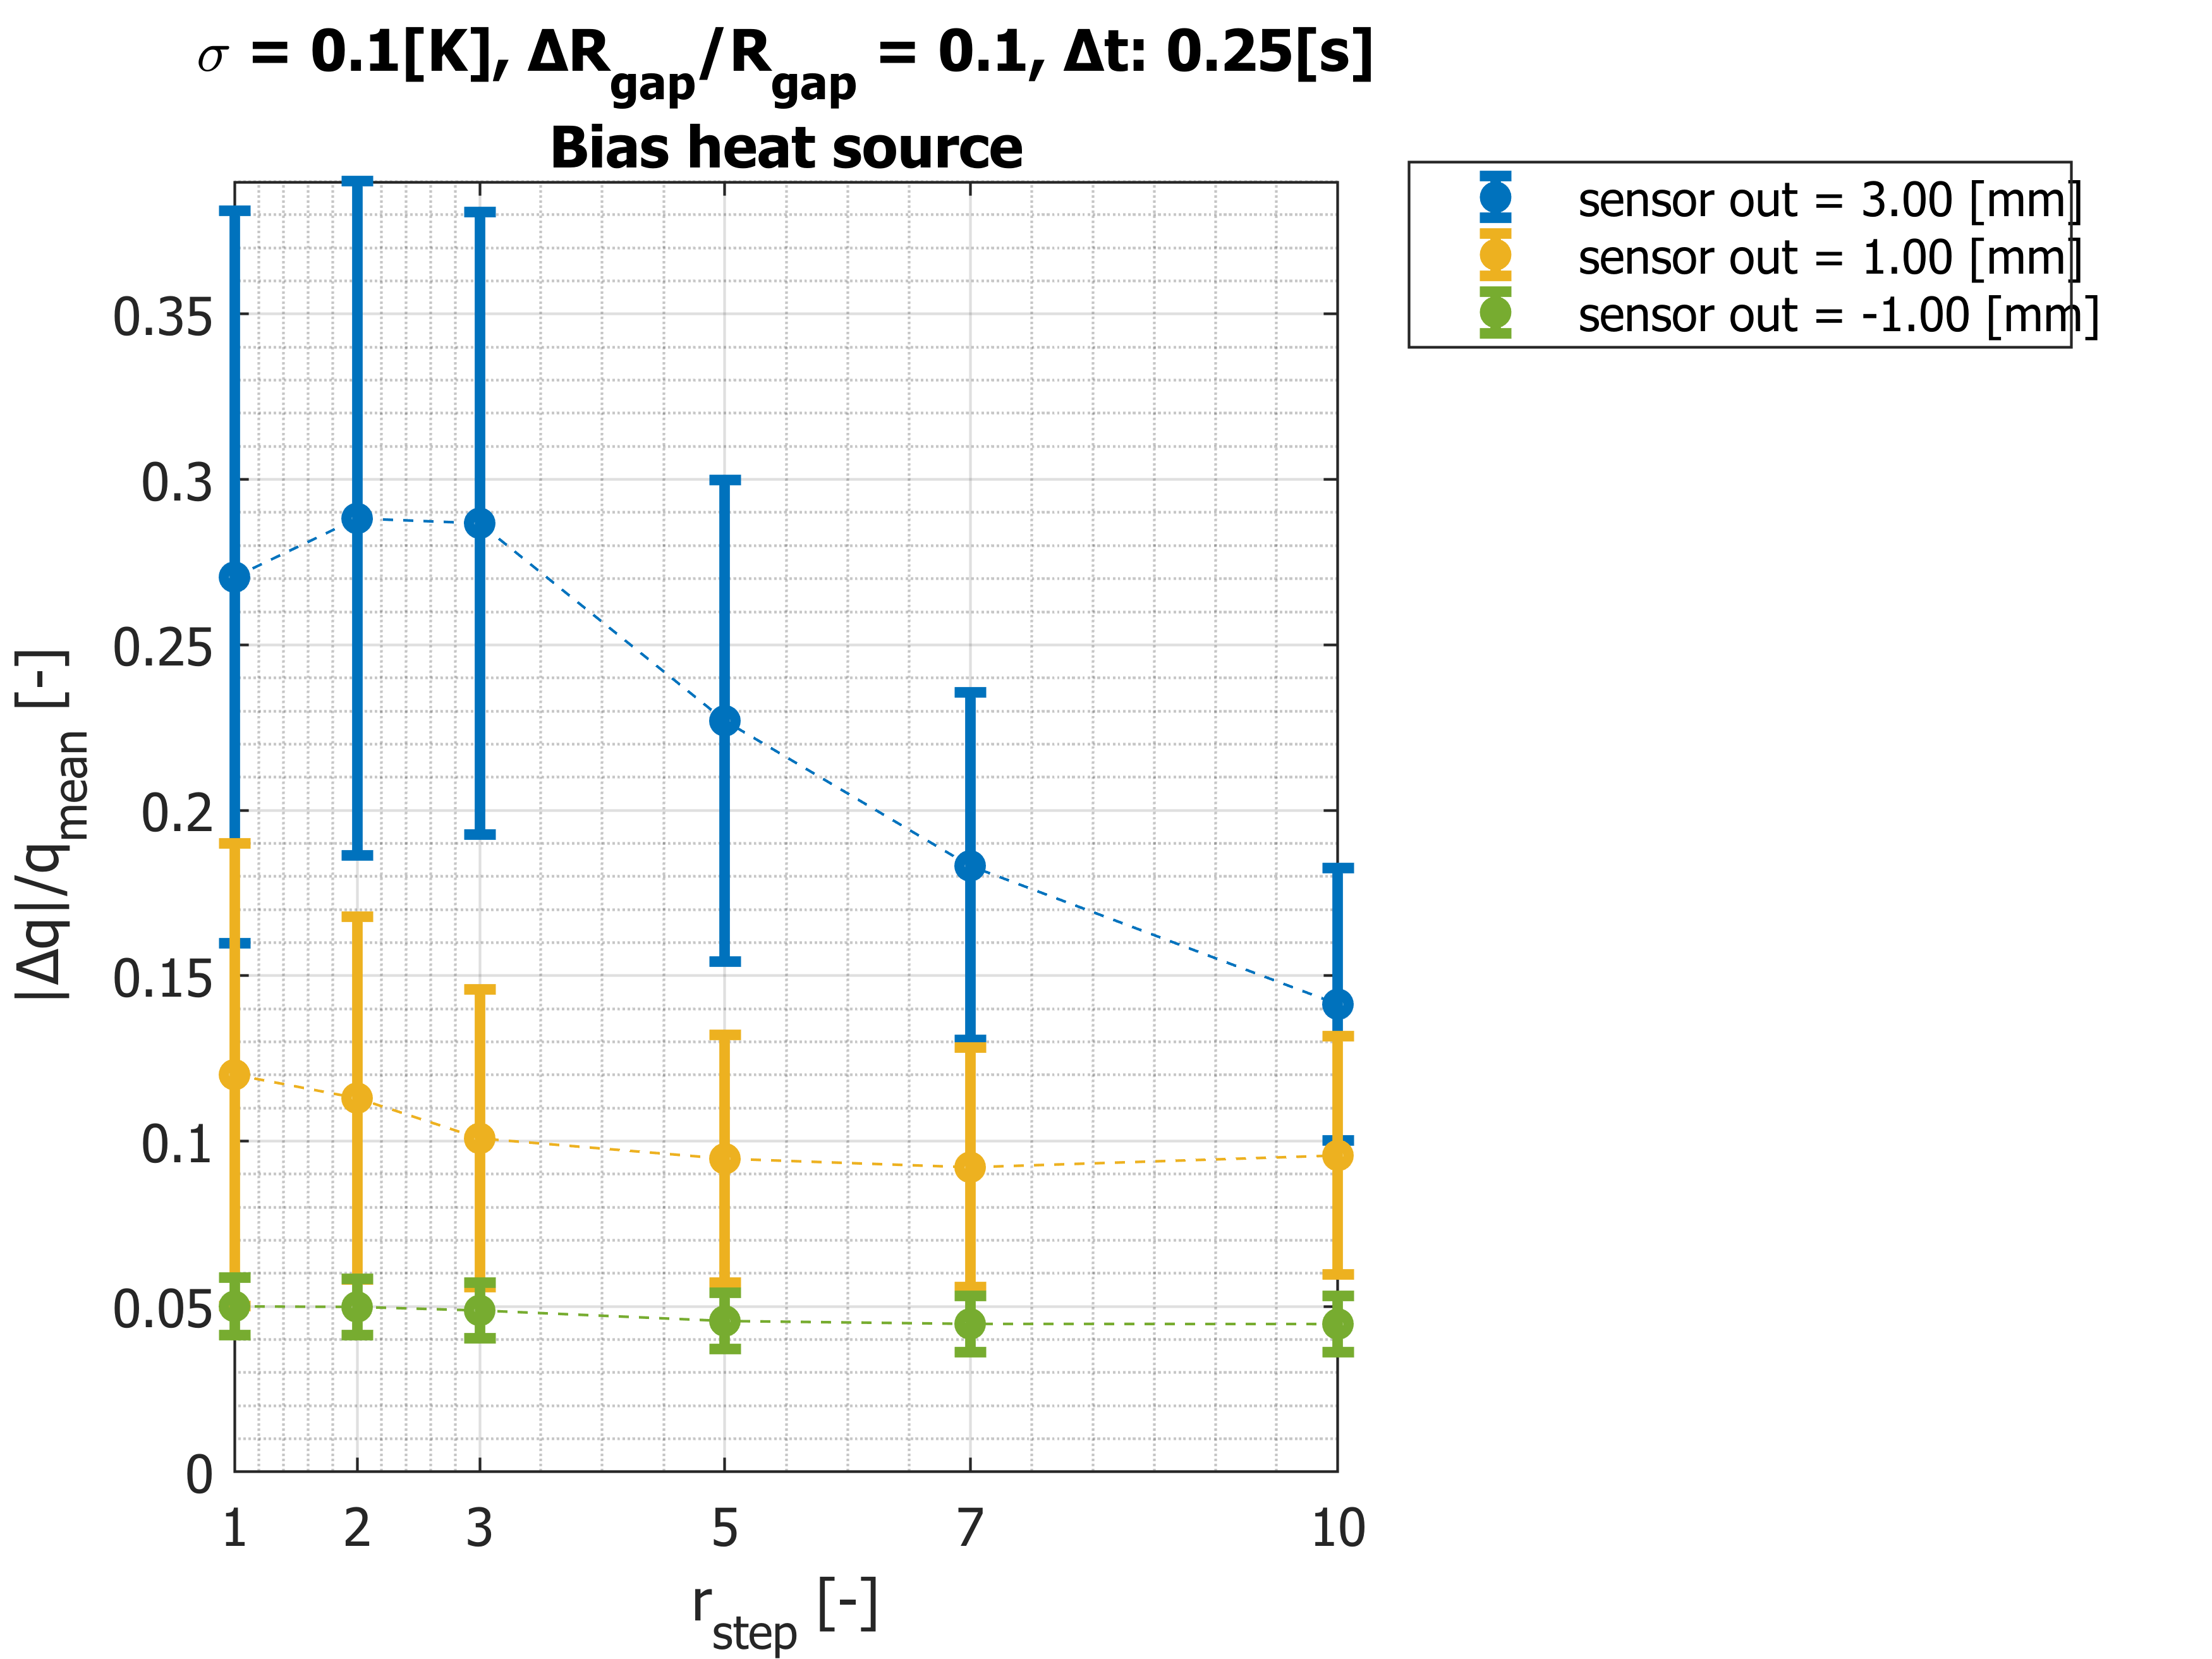

In [6]:
% subplot(2,1,1)
for ip=Np:-1:1
    tempvar = (sensor_user_input(ip)-N_grid_heater)*dr*1000;
    e = errorbar(r_steps, q_error_normalized_save_EnK(:, ip), q_std_normalized_save_EnK(:, ip)/sqrt(M_sample), ...
        'o','displayname',sprintf('sensor out = %1.2f [mm]', tempvar));
    e.MarkerSize = 4;
    e.LineWidth = 2;
    hold on

    % Plot the dashed line connecting the points
    plot(r_steps, q_error_normalized_save_EnK(:, ip), '--', 'Color', e.Color,'HandleVisibility', 'off');
    hold on;
end

xlabel('r_{step} [-]');
ylabel('|Δq|/q_{mean} [-]');
title({
    ['\sigma = ', num2str(sigma_noise), '[K], ΔR_{gap}/R_{gap} = ', num2str(Rgap_noise), ', Δt: ', num2str(dt) '[s]'],...
    'Bias heat source'
});

xticks(r_steps);               % Set x-ticks to r_steps values
xticklabels(string(r_steps));  % Set x-tick labels to r_steps values
set(gca,'FontSize',10,'fontname','times')
legend('show','location','northeastoutside')
xlim([1 inf])
ylim([0 inf])
grid on
grid minor

## peak temperature error


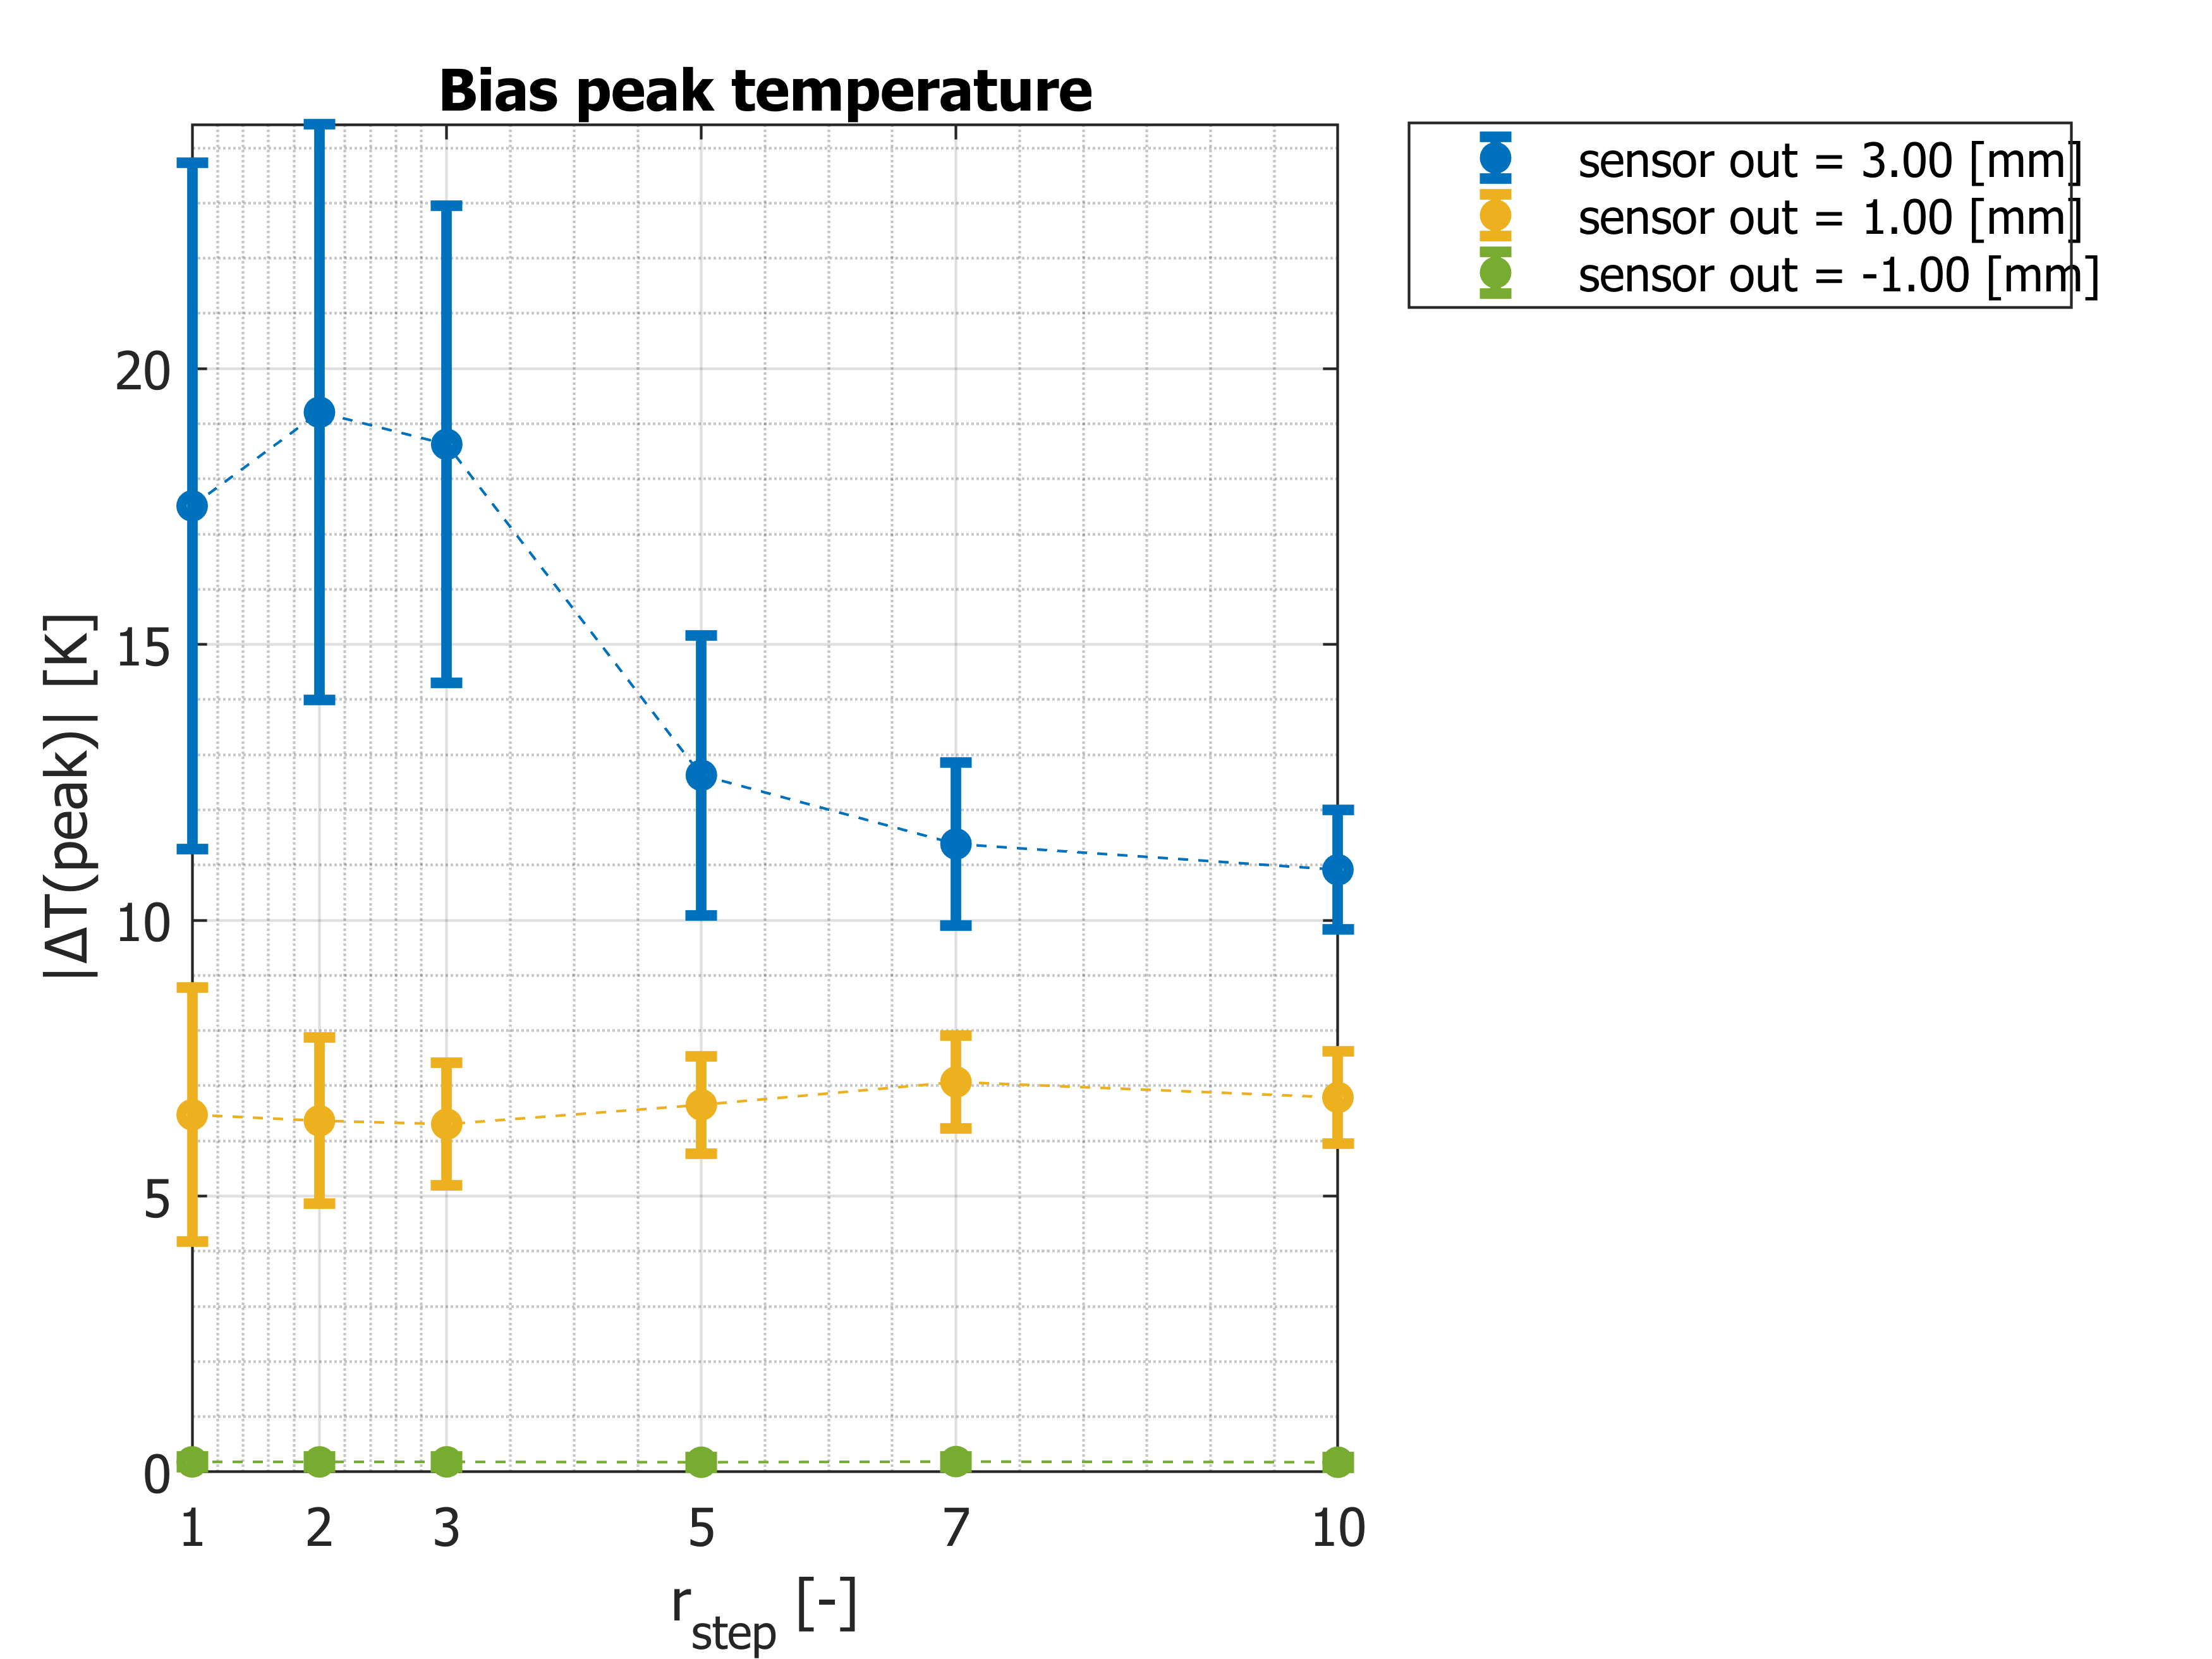

In [7]:
figure;
set(gcf, 'WindowState', 'maximized');
for ip=Np:-1:1
    tempvar = (sensor_user_input(ip)-N_grid_heater)*dr*1000;
    e = errorbar(r_steps, T_peak_error_save_EnK(:, ip), T_peak_std_save_EnK(:, ip)/sqrt(M_sample), ...
        'o','displayname',sprintf('sensor out = %1.2f [mm]', tempvar));
    e.MarkerSize = 4;
    e.LineWidth = 2;
    hold on

    % Plot the dashed line connecting the points
    plot(r_steps, T_peak_error_save_EnK(:, ip), '--', 'Color', e.Color,'HandleVisibility', 'off');
    hold on;
end

xlabel('r_{step} [-]');
ylabel('|ΔT(peak)| [K]');
title('Bias peak temperature');
xticks(r_steps);               % Set x-ticks to r_steps values
xticklabels(string(r_steps));  % Set x-tick labels to r_steps values
set(gca,'FontSize',10,'fontname','times')
legend('show','location','northeastoutside')
xlim([1 inf])
ylim([0 inf])
grid on
grid minor